![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
#### In this competition we have to prognose rating of a restaurant in TripAdvisor, having cleaned and prepared data for a ML model given.

# import

In [1]:
# import of necessary libraries for work:

from textblob import TextBlob  # tonal analisys llibrary
import math
from datetime import datetime, timedelta  # working with dates libarary
from datetime import date
import re
import os
from scipy import stats
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
# tool for dividig data for test and training
from sklearn.model_selection import train_test_split
import numpy as np  # linear algebra
import pandas as pd  # explorative analisys

# visualisation libraries:
import matplotlib.pyplot as plt  # 2-d graphics
import seaborn as sns  # graphics for statistics
%matplotlib inline


# looking files in directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# fixing random seed  for reproduction of results
RANDOM_SEED = 42

In [3]:
# writing down requirements
!pip freeze > requirements.txt

### Functions

In [4]:
def misses_in_attr(data, list_attr):
    """Misses count and writing them in a new attribute"""
    data_misses = pd.DataFrame()
    for attr in list_attr:
        data_misses[attr+'_misses'] = pd.isna(data[attr]).astype('uint8')
    return data_misses


def IQR_for_column(column):
    """Return of quantiles and outliers due IQR, oulliers count and normalization"""
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    IQR = perc75 - perc25
    min_out = perc25 - 1.5*IQR
    max_out = perc75 + 1.5*IQR
    anomaly = len(data[data[column] > max_out]) + \
        len(data[data[column] < min_out])
    print(
        '25 percentile: {} |'.format(perc25),
        '75 percentile: {} |'.format(perc75),
        "IQR: {} | ".format(IQR),
        "Outliers limits: [{}, {}].".format(min_out, max_out))
    print("Outliers, due IQR: {} | {:2.2%}".format(
        anomaly, anomaly/len(data)))


def normalization(x, x_min, x_max):
    '''Attribute normalization'''
    return (x-x_min)/(x_max-x_min)


def get_min_max_normalization(df, column):
    """Attribute normalization due min & max """
    x_min, x_max = df[column].agg(['min', 'max'])
    return normalization(df[column], x_min, x_max)

# DATA

Data download and description:

In [5]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
# data for model training with target attribute
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
# data for prognosis and its evaluation
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
# a sample of submission file
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [7]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


 In training dataset there are 40 000 rows and 10 columns-attributes. There are data misses.

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [9]:
df_test.head(8)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354
5,id_5,Paris,"['French', 'Cafe', 'Fast Food']",5093.0,$,24.0,"[['Lunch Break', 'Good to Quick Bite'], ['09/0...",/Restaurant_Review-g187147-d8458643-Reviews-Le...,d8458643
6,id_6,Lisbon,"['European', 'Portuguese']",3704.0,$,2.0,"[[], []]",/Restaurant_Review-g189158-d8758873-Reviews-Li...,d8758873
7,id_7,Budapest,NaN,2330.0,NaN,NaN,"[[], []]",/Restaurant_Review-g274887-d8286886-Reviews-Be...,d8286886


Data for testing have the same structure as training one, 10 000 rows and same 10 columns-attributes, except target attribute Rating.

In [10]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


Sample. 10000 entries with 2 attributes.

In [12]:
# ATT! For correct processing it's necessary to gather training and testing datasets.
df_train['sample'] = 1  # training data
df_test['sample'] = 0  # testing data

# in testing data target attribute is missed and have to be prognosed, so we fill it with 0 now.
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(drop=True)  # gathering

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Attribute description:
* City: city 
* Cuisine Style: cuisine style
* Ranking: rank of a restaurant in relation to all other restaurants of the city
* Price Range: price range in 3 groups
* Number of Reviews: reviews quantity
* Reviews: two las reviews and their dates
* URL_TA: wep page of a restaurant on 'www.tripadvisor.com' 
* ID_TA: ID of a restaurant in TripAdvisor
* Rating: restaurant rating

# Data check and clean


Duplicates check:

In [14]:
data.duplicated(subset=None, keep='first').value_counts()

False    50000
dtype: int64

There is no full duplicates in data but there are misses. Let's count and picture it.

Найдено пропусков значений: 32153


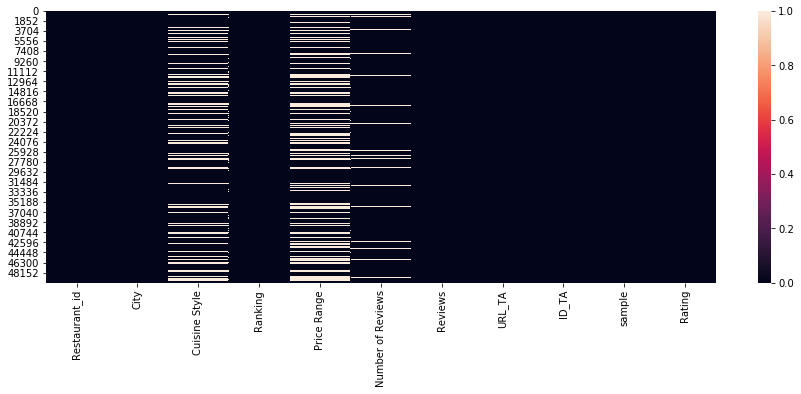

In [15]:
print('Misses detected:', data.isnull().sum().sum())

plt.subplots(figsize=(15, 5))
sns.heatmap(data.isnull())

In [16]:
data_misses = data.isnull().sum()
data_misses[data_misses > 0]

Cuisine Style        11590
Price Range          17361
Number of Reviews     3200
Reviews                  2
dtype: int64

In [17]:
# listed attributes with misses:
attr_list = ['Cuisine Style', 'Price Range', 'Number of Reviews', 'Reviews']

# gathering attributes with misses frame with data
attr_misses = misses_in_attr(data, attr_list)
data = pd.concat([data, attr_misses], axis=1)

Let's describe all attributes.

# EDA

### 'Restaurant_id'


Restaurant id, should be individual for every single restaurant. Checking for duplicates and misses:

In [18]:
len(data['Restaurant_id'].value_counts().loc[lambda x: x > 1].index)

9287

Duplicates. Exploring closer 10 first listed duplicates:

In [19]:
data['Restaurant_id'].value_counts().loc[lambda x: x > 1].index[:10]

Index(['id_227', 'id_633', 'id_436', 'id_871', 'id_534', 'id_430', 'id_585',
       'id_344', 'id_71', 'id_321'],
      dtype='object')

In [20]:
data[data['Restaurant_id'] == 'id_871'].sample(2)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Cuisine Style_misses,Price Range_misses,Number of Reviews_misses,Reviews_misses
38923,id_871,Dublin,"['American', 'Irish', 'Barbecue']",872.0,$$ - $$$,10.0,"[['Good food', 'Our new favourite BBQ joint'],...",/Restaurant_Review-g186605-d12713994-Reviews-S...,d12713994,1,4.5,0,0,0,0
47161,id_871,Paris,"['Lebanese', 'Mediterranean', 'Middle Eastern'...",872.0,$$ - $$$,476.0,"[['Great food and lovely atmosphere', 'Beautif...",/Restaurant_Review-g187147-d719561-Reviews-Res...,d719561,1,4.0,0,0,0,0


Rows with same Restaurant_id have different City, Cuisine Style and other attributes. May be those show attribution to a restaurant chain or same owner. Let's write it down in a new attribute.  

In [21]:
# filter ids and listing repeating ones
data_id = data[data['Restaurant_id'].map(
    data['Restaurant_id'].value_counts()) >= 2]
repeated_id = data_id['Restaurant_id'].tolist()

data['twin_id'] = data['Restaurant_id'].apply(
    lambda x: 1 if x in repeated_id else 0)

In [22]:
# deleting letters and signs for model processing
data['Restaurant_id'] = data['Restaurant_id'].apply(lambda x: int(x[3:]))

### 'City'

No misses in City.

Let's visualize distribution.

In [23]:
# adding attribute of restaurants quantity in a city
city_restaurants_num = data['City'].value_counts(
).sort_index(ascending=True).to_dict()
data['rest_num_city'] = data['City'].map(city_restaurants_num)

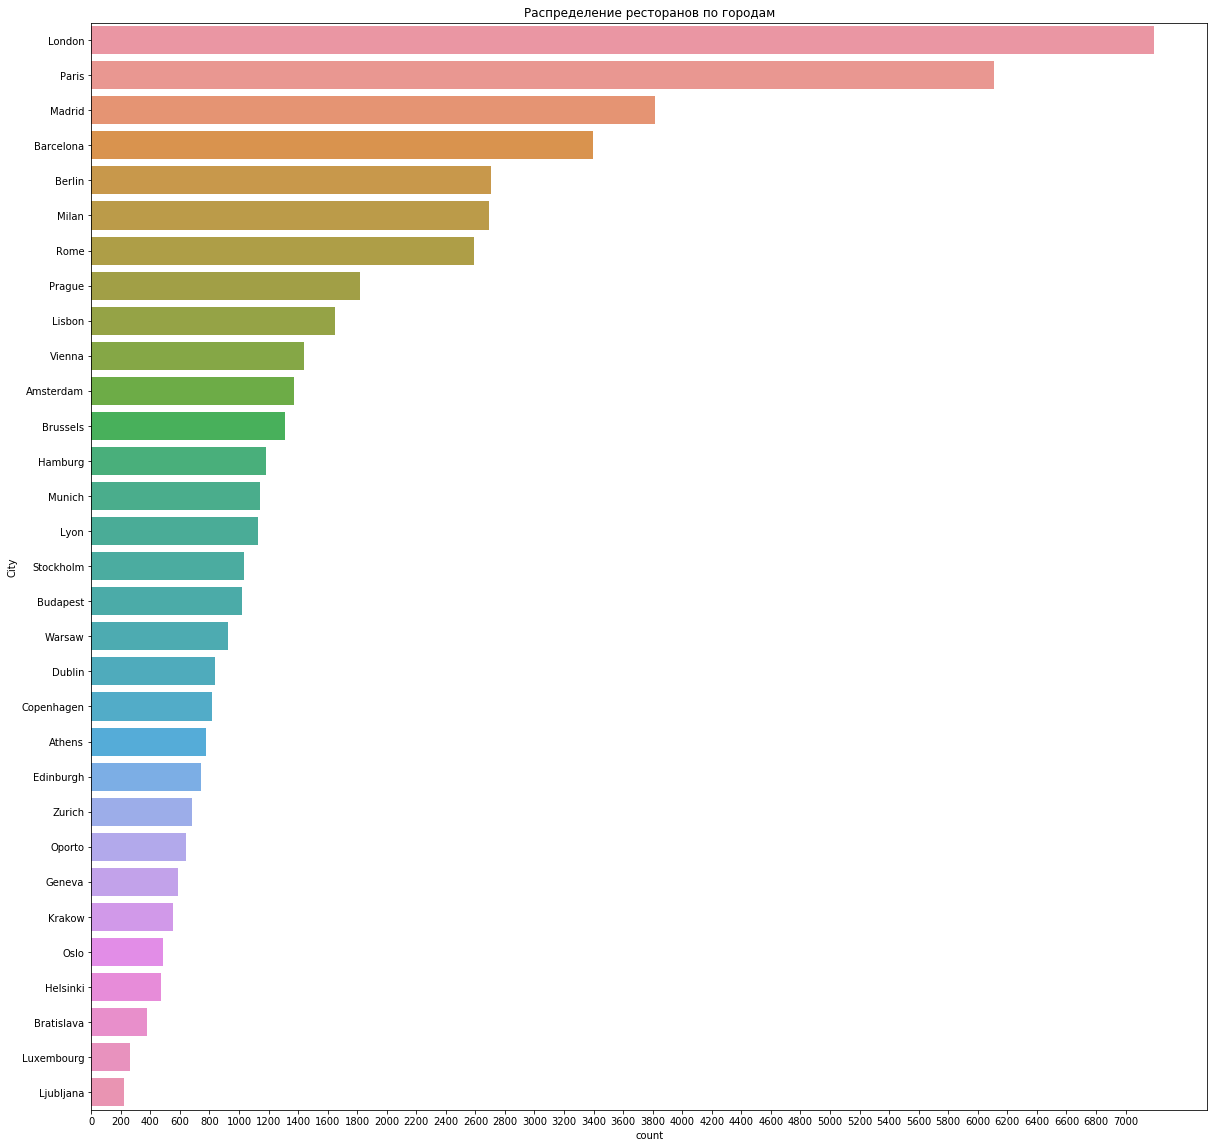

In [24]:
plt.subplots(figsize=(20, 20))
plt.xticks(ticks=range(0, 7200, 200))
plt.title('Restaurants distribution by cities')
sns.countplot(y='City',
              data=data,
              order=data.City.value_counts().index)
plt.xlabel = 'Restaurant quantity'

7 outstanding cities are well seen here.

In [25]:
# city names check
cities_list = list(data['City'].value_counts().index)
cities_list

['London',
 'Paris',
 'Madrid',
 'Barcelona',
 'Berlin',
 'Milan',
 'Rome',
 'Prague',
 'Lisbon',
 'Vienna',
 'Amsterdam',
 'Brussels',
 'Hamburg',
 'Munich',
 'Lyon',
 'Stockholm',
 'Budapest',
 'Warsaw',
 'Dublin',
 'Copenhagen',
 'Athens',
 'Edinburgh',
 'Zurich',
 'Oporto',
 'Geneva',
 'Krakow',
 'Oslo',
 'Helsinki',
 'Bratislava',
 'Luxembourg',
 'Ljubljana']

ok, later will be coded with dummy-variables. 

Let's try to enrich data  with info about population in cities.

In [26]:
# Adding population in thousands
сity_population = {'London': 10979, 'Paris': 11020, 'Madrid': 6026, 'Barcelona': 4588,
                   'Berlin': 6177, 'Milan': 4907, 'Rome': 3900, 'Prague': 1308,
                   'Lisbon': 2942, 'Vienna': 2300, 'Amsterdam': 2400, 'Brussels': 1831,
                   'Hamburg': 1841, 'Munich': 1471, 'Lyon': 1748, 'Stockholm': 2352,
                   'Budapest': 2965, 'Warsaw': 3100, 'Dublin': 1347,
                   'Copenhagen': 1308, 'Athens': 3168, 'Edinburgh': 513,
                   'Zurich': 1334, 'Oporto': 1313, 'Geneva': 496, 'Krakow': 1200,
                   'Oslo': 1558, 'Helsinki': 1299, 'Bratislava': 700,
                   'Luxembourg': 626, 'Ljubljana': 508}


data['city_population'] = data['City'].map(сity_population)

In [27]:
# adding attribute of restaurants density per thousand
data['restaurants_density'] = data['rest_num_city'] / data['city_population']

In [28]:
# adding attribute of top count restaurants cities
top_restaurants_count = ['London', 'Paris', 'Milan',
                         'Rome', 'Berlin', 'Madrid', 'Barcelona']
data['top_restaurants_count'] = data['City'].apply(
    lambda x: 1 if x in top_restaurants_count else 0)

## 'Cuisine Style'

Attribute with misses. Let's count them. 

In [29]:
data['Cuisine Style'].isnull().sum()

11590

A lot of misses. Let's find most popular cuisine styles in data and every city.

In [30]:
data[['City', 'Cuisine Style']].groupby('City').describe()

Cuisine Style                                          
                   count unique                           top freq
City                                                              
Amsterdam           1170    717         ['Dutch', 'European']   33
Athens               627    302                     ['Greek']   92
Barcelona           2608   1021                   ['Spanish']  249
Berlin              1793    784                   ['Italian']   96
Bratislava           236    162                       ['Pub']   15
Brussels             992    491       ['Belgian', 'European']   54
Budapest             819    509     ['European', 'Hungarian']   72
Copenhagen           616    360        ['European', 'Danish']   21
Dublin               704    440       ['Irish', 'Bar', 'Pub']   24
Edinburgh            649    412                      ['Cafe']   17
Geneva               474    261                    ['French']   23
Hamburg              666    349                   ['Italian']   29
Helsinki             373    235  ['European', 'Scandinavian']   11
Krakow               436    282        ['Polish', 'European']   42
Lisbon              1248    513    ['European', 'Portuguese']  269
Ljubljana            189    146     ['European', 'Slovenian']   10
London              5983   2220     ['Bar', 'British', 'Pub']  209
Luxembourg           222    143                    ['French']   11
Lyon                 747    255                    ['French']  192
Madrid              2634    857                   ['Spanish']  514
Milan               1986    700                   ['Italian']  335
Munich               816    429                   ['Italian']   34
Oporto               492    246    ['European', 'Portuguese']  100
Oslo                 388    292                       ['Pub']   10
Paris               4800   1153                    ['French']  674
Prague              1509    651         ['European', 'Czech']  228
Rome                2270    854                   ['Italian']  230
Stockholm            723    390       ['European', 'Swedish']   35
Vienna              1041    573      ['Austrian', 'European']   90
Warsaw               671    381        ['Polish', 'European']   52
Zurich               528    362         ['Swiss', 'European']   19

Listing all cuisine styles. Cuisine Style count will be written to cuisine_styles_num. For restaurants with no style indicated will take as one style.

In [31]:
data['Cuisine Style'].fillna('[]', inplace=True)
data['Cuisine Style'] = data['Cuisine Style'].apply(
    lambda x: str(x).replace('[', '').replace(']', '').replace("'", '').replace(' ', '').replace('"', ''))
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: x.split(','))
data['cuisine_styles_num'] = data['Cuisine Style'].apply(lambda x: len(x))

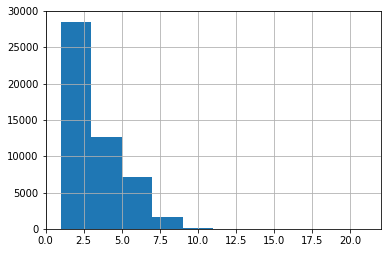

In [32]:
data['cuisine_styles_num'].hist()

In [33]:
IQR_for_column('cuisine_styles_num')

25-й перцентиль: 1.0 | 75-й перцентиль: 4.0 | IQR: 3.0 |  Границы выбросов: [-3.5, 8.5].
Выбросов, согласно IQR: 126 | 0.25%


25% of values in outliers is too mach, so those possibly represent a group of restaurants with  many cuisine styles as a special feature.

Maximum cuisine styles in a restaurant are:

In [34]:
data['cuisine_styles_num'].max()

21

Quite a lot but not out of the possible limits.

## 'Ranking'

Rank position of a restaurant comparing it to all the others in the city. Let's picture it's disrtibution.

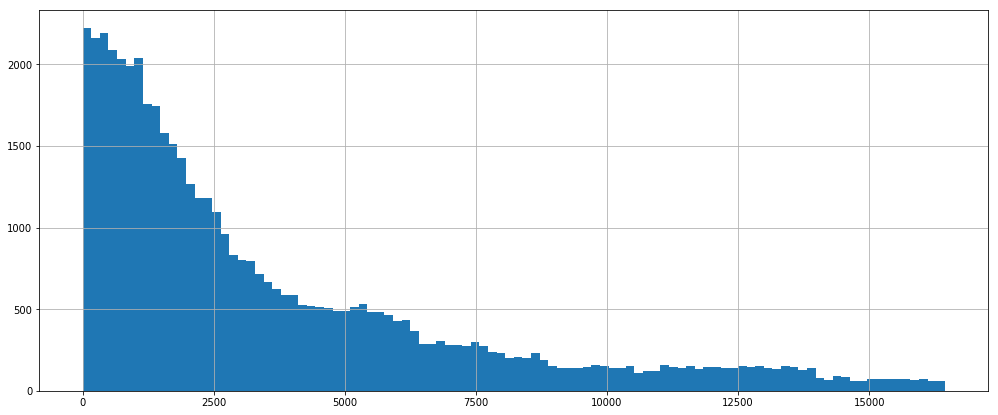

In [35]:
plt.subplots(figsize=(17, 7))
plt.rcParams['figure.figsize'] = (10, 7)
data['Ranking'].hist(bins=100)

The majority of restaurants don't get the 2500 place in city.

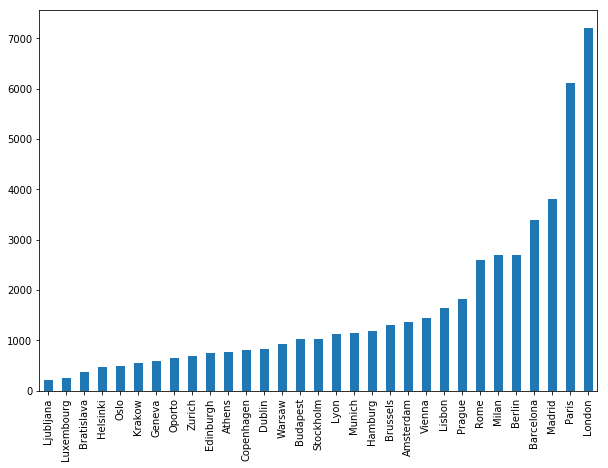

In [36]:
data['City'].value_counts(ascending=True).plot(kind='bar')

Restaurant's general distribution is quite far from normal, let's look closer for the distribution for top 10 cities.

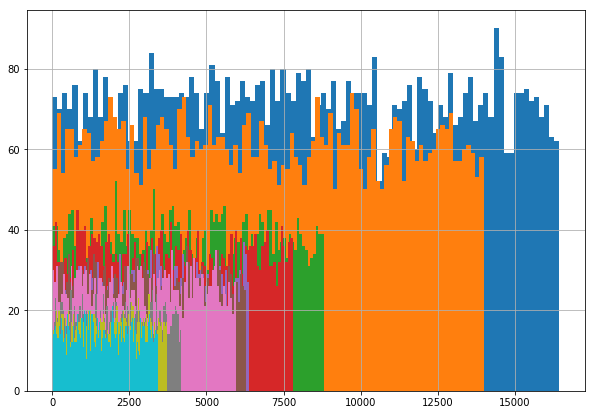

In [37]:
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100)
plt.show()

Ranking is counted for all the restaurants of a city, so looking for the distribution for the entire datase we loose information about scale for every city. let's make a new attribute: relation of Ranking to maximus Ranking of a city.

In [38]:
city_top_ranking = data.groupby('City')['Ranking'].max().to_dict()
city_top_ranking

{'Amsterdam': 3254.0,
 'Athens': 1787.0,
 'Barcelona': 7796.0,
 'Berlin': 6372.0,
 'Bratislava': 889.0,
 'Brussels': 3006.0,
 'Budapest': 2440.0,
 'Copenhagen': 1964.0,
 'Dublin': 1960.0,
 'Edinburgh': 1766.0,
 'Geneva': 1413.0,
 'Hamburg': 2737.0,
 'Helsinki': 1141.0,
 'Krakow': 1244.0,
 'Lisbon': 3717.0,
 'Ljubljana': 468.0,
 'London': 16444.0,
 'Luxembourg': 621.0,
 'Lyon': 2666.0,
 'Madrid': 8809.0,
 'Milan': 6275.0,
 'Munich': 2763.0,
 'Oporto': 1484.0,
 'Oslo': 1137.0,
 'Paris': 13986.0,
 'Prague': 4188.0,
 'Rome': 5948.0,
 'Stockholm': 2464.0,
 'Vienna': 3444.0,
 'Warsaw': 2154.0,
 'Zurich': 1601.0}

In [39]:
# maximal Ranking for every city
data['city_top_ranking'] = data['City'].map(city_top_ranking)

In [40]:
# ranking scaled to maximal ranking of a city
data['ranking_scaled'] = data['Ranking'] / data['city_top_ranking']

In [41]:
# relative position of restaurant in a city
data['relative_ranking'] = data['Ranking'] / data['rest_num_city']

In [42]:
# normalize ranking & number of restaurant
data['norm_rest'] = data['rest_num_city']/data['Ranking']

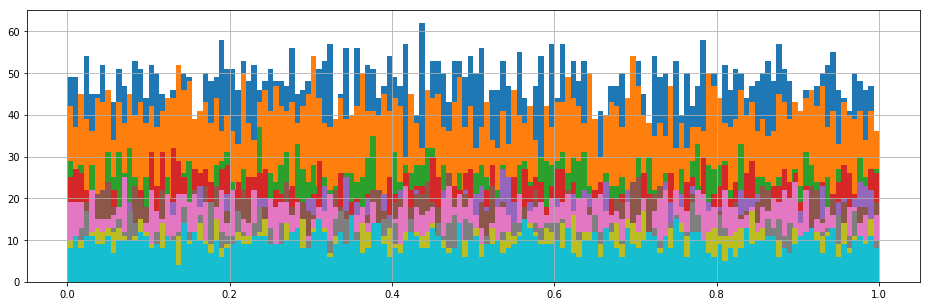

In [43]:
# illustration of distributuion of ranking scaled for top-10 cities of dataset
for x in (data['City'].value_counts())[0:10].index:
    data['ranking_scaled'][data['City'] == x].hist(bins=150, figsize=(16, 5))

Ranking scaled shows it's feature in a same scale for every city.

## 'Price Range'

Exploring price diapazones represented in dataset.

In [44]:
data['Price Range'].value_counts(dropna=False)

$$ - $$$    23041
NaN         17361
$            7816
$$$$         1782
Name: Price Range, dtype: int64

All the values lay in 3 diapazones without outliers, but 17361 restaurants have no price range attribution. Those misses should be filled. Let's find the most common price range for cities.

In [45]:
data[['City', 'Price Range']].groupby('City').describe()

Price Range                       
                 count unique       top  freq
City                                         
Amsterdam         1052      3  $$ - $$$   794
Athens             532      3  $$ - $$$   328
Barcelona         2257      3  $$ - $$$  1561
Berlin            1448      3  $$ - $$$   964
Bratislava         176      3  $$ - $$$   124
Brussels           858      3  $$ - $$$   639
Budapest           699      3  $$ - $$$   446
Copenhagen         542      3  $$ - $$$   414
Dublin             634      3  $$ - $$$   466
Edinburgh          600      3  $$ - $$$   388
Geneva             402      3  $$ - $$$   318
Hamburg            525      3  $$ - $$$   388
Helsinki           317      3  $$ - $$$   237
Krakow             377      3  $$ - $$$   220
Lisbon            1085      3  $$ - $$$   704
Ljubljana          158      3  $$ - $$$   104
London            5196      3  $$ - $$$  3651
Luxembourg         189      3  $$ - $$$   163
Lyon               597      3  $$ - $$$   469
Madrid            2122      3  $$ - $$$  1560
Milan             1620      3  $$ - $$$   990
Munich             726      3  $$ - $$$   554
Oporto             441      3  $$ - $$$   259
Oslo               334      3  $$ - $$$   250
Paris             4121      3  $$ - $$$  3109
Prague            1117      3  $$ - $$$   743
Rome              2060      3  $$ - $$$  1317
Stockholm          554      3  $$ - $$$   458
Vienna             866      3  $$ - $$$   665
Warsaw             562      3  $$ - $$$   393
Zurich             472      3  $$ - $$$   365

The majority of restaurants have middle price level. Let's code the attribute in numerals so that it could be used for ML, bearing in mind an attribute have ordered levels.

In [46]:
data['Price Range'] = data['Price Range'].apply(
    lambda x: 1 if x == '$' else 2 if x == '$$ - $$$' else 3 if x == '$$$$' else x)

misses to be filled with most common value - 2

In [47]:
data['Price Range'] = data['Price Range'].fillna(2)

In [48]:
data['Price Range'].isnull().sum()

0

## 'Number of Reviews'

Let's explore  Number of Reviews.

In [49]:
data['Number of Reviews'].value_counts(dropna=False)

NaN       3200
2.0       2403
3.0       2042
4.0       1707
5.0       1471
          ... 
5216.0       1
1932.0       1
1050.0       1
1145.0       1
1471.0       1
Name: Number of Reviews, Length: 1574, dtype: int64

3200 misses have to be filled. Main statistics are: 

Distribution seems to be very uneven, let's illustrate it.

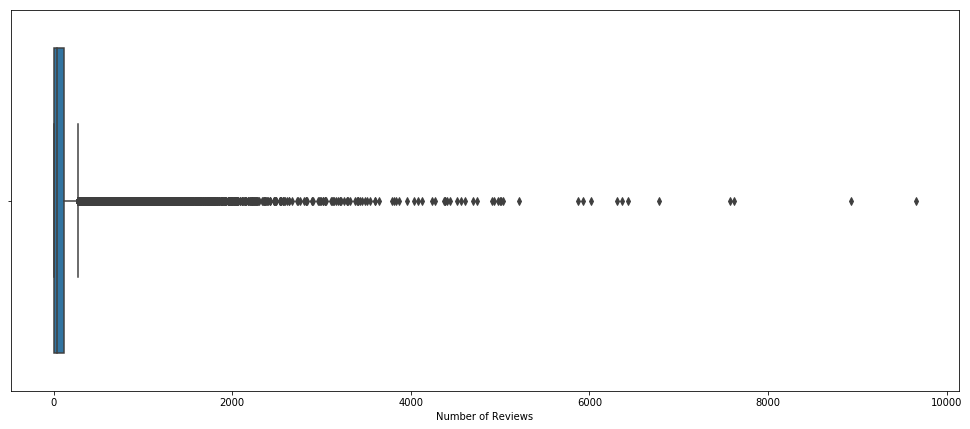

In [51]:
plt.subplots(figsize=(17, 7))
sns.boxplot(data['Number of Reviews'])

It's very well seen that a lot of restaurants don't have counted reviews at all, and there some with outliing values.
Let's fill the misses with median as it's not so sensetive to outliers.

In [52]:
# filling misses with median
data.loc[data['Price Range'].isnull(), 'Price Range'] = data.groupby(
    'City').transform('median')

# Let's try to minimize a right bias by changing values over 5000 to 5000.
data['Number of Reviews'] = data['Number of Reviews'].apply(
    lambda x: x if x <= 5000 else 5000)

In [53]:
# taking logarithm to normalize distribution
data['log_number_of_reviews'] = np.log(data['Number of Reviews'] + 1)

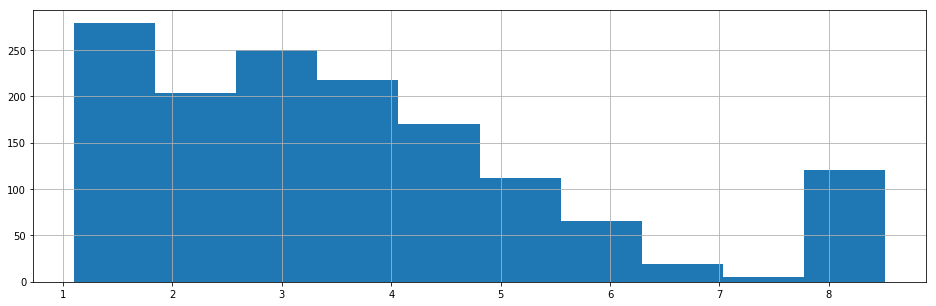

In [54]:
data['log_number_of_reviews'][data['City'] == x].hist(bins=10, figsize=(16, 5))

In [55]:
IQR_for_column('log_number_of_reviews')

25-й перцентиль: 2.3978952727983707 | 75-й перцентиль: 5.045032839501819 | IQR: 2.6471375667034485 |  Границы выбросов: [-1.572811077256802, 9.015739189556992].
Выбросов, согласно IQR: 0 | 0.00%


In [56]:
# adding attribute of number of reviews related to city population
data['reviews_to_population'] = data['Number of Reviews'] / data[
    'city_population']

# adding attribute of weighted ranking related to relative reviews number
data['weighted_rank_pop'] = data['relative_ranking'] * data[
    'reviews_to_population']

## 'Reviews'

Object-attribute with complicated structure. Let's explore it.

In [57]:
data['Reviews'].value_counts(dropna=False)

[[], []]                                                                                                                8112
NaN                                                                                                                        2
[['The real codido madrileño'], ['03/31/2017']]                                                                            2
[['Sat night', 'Can\'t even explain.. "A" place.. A "100...'], ['10/22/2017', '05/11/2017']]                               2
[['Very good all around', 'Our first Madrid restaurant'], ['11/20/2017', '10/11/2017']]                                    2
                                                                                                                        ... 
[['I do not recommend', 'Avoid this place'], ['09/24/2017', '01/12/2017']]                                                 1
[['The best view of the Gran Via', 'WOW'], ['01/21/2016', '04/04/2015']]                                                   1


In [58]:
# filling misses with most common value
data['Reviews'].fillna('[[], []]', inplace=True)

In [59]:
# making attribute review_date with list of dates of review
data['review_dates'] = data['Reviews'].str.findall('\d+\/\d+\/\d+')
data['review_dates'].sample(5)

16826    [10/08/2017, 10/03/2017]
9172     [09/21/2016, 04/16/2016]
44795    [10/02/2017, 05/04/2017]
20002    [12/08/2017, 12/06/2017]
27318                          []
Name: review_dates, dtype: object

In [60]:
# check dates in reviews
data['dates_count'] = data['review_dates'].apply(lambda x: len(list(x)))
data['dates_count'].value_counts()

2    36202
0     8114
1     5680
3        4
Name: dates_count, dtype: int64

In [61]:
data[data['dates_count'] == 3]['Reviews']

2221     [['We visited 21/10/17', 'Best Kebab in London...
3809     [['Good Museum Cafeteria', 'Lunch 30/5/2017'],...
19254    [['The desserts arcade !', 'Visit today 3/1/20...
33348    [['lunch 29/9/2016', 'Unplanned Great Dinner']...
Name: Reviews, dtype: object

In [62]:
# deleting dates already writed downn in review text
data['review_dates'] = data['review_dates'].apply(
    lambda x: x if len(x) <= 2 else x[1:])

In [63]:
# dividing Review_date to First_review and Last_review
data['first_review'] = data['review_dates'].apply(
    lambda x: pd.to_datetime(x).min())
data['last_review'] = data['review_dates'].apply(
    lambda x: pd.to_datetime(x).max())

# making new attribute Between_reviews with difference in days between first and last review
data['between_reviews'] = (data['last_review'] -
                           data['first_review']).apply(lambda x: x.days)

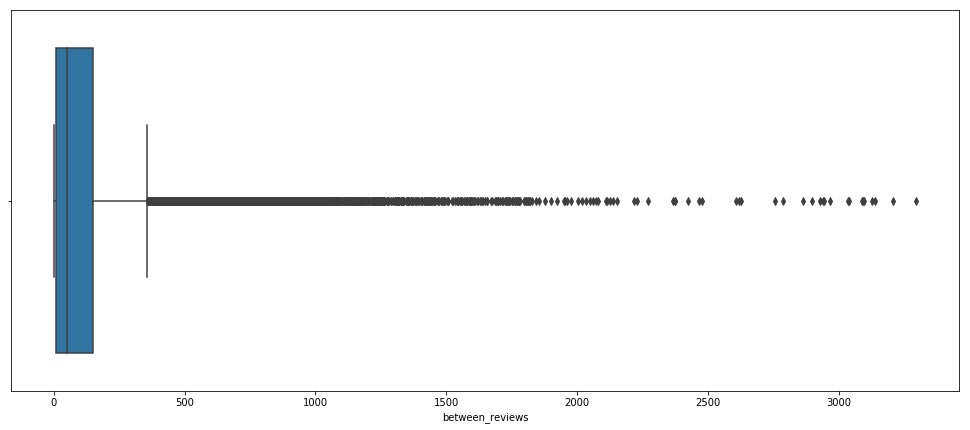

In [64]:
plt.subplots(figsize=(17, 7))
sns.boxplot(data['between_reviews'])

In [65]:
# filling misses with rounded median value
data['between_reviews'].fillna(
    round(data['between_reviews'].median()), inplace=True)

In [66]:
# finding how many days ago was first and last review written
today = pd.to_datetime(date.today().strftime("%Y-%m-%d"))
data['last_review_days_ago'] = data['last_review'].apply(lambda x: today - x)
data['last_review_days_ago'] = data['last_review_days_ago'].apply(
    lambda x: x.days)

data['first_review_days_ago'] = data['first_review'].apply(lambda x: today - x)
data['first_review_days_ago'] = data['first_review_days_ago'].apply(
    lambda x: x.days)

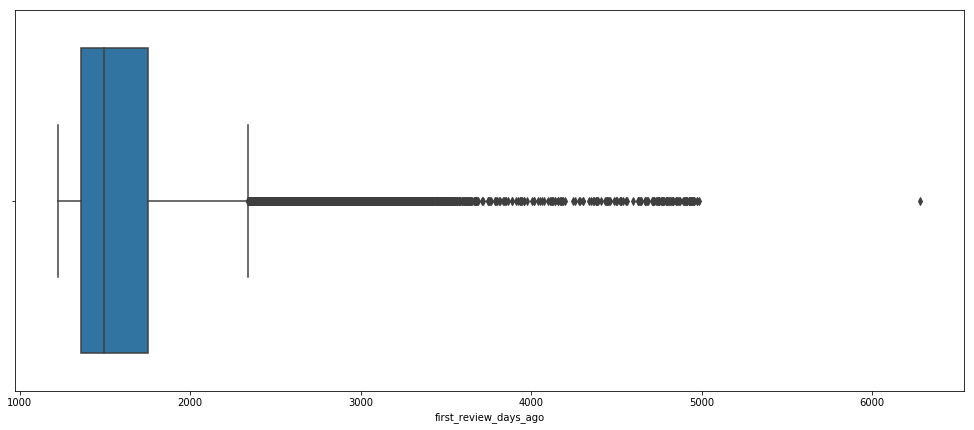

In [67]:
# illustrating distribution of feature
plt.subplots(figsize=(17, 7))
sns.boxplot(data['first_review_days_ago'])

In [68]:
# there is an obvious outlier more than 6000 days ago, let's change it to 5000
data['first_review_days_ago'] = data['first_review_days_ago'].apply(
    lambda x: 5000 if x >= 6000 else x)

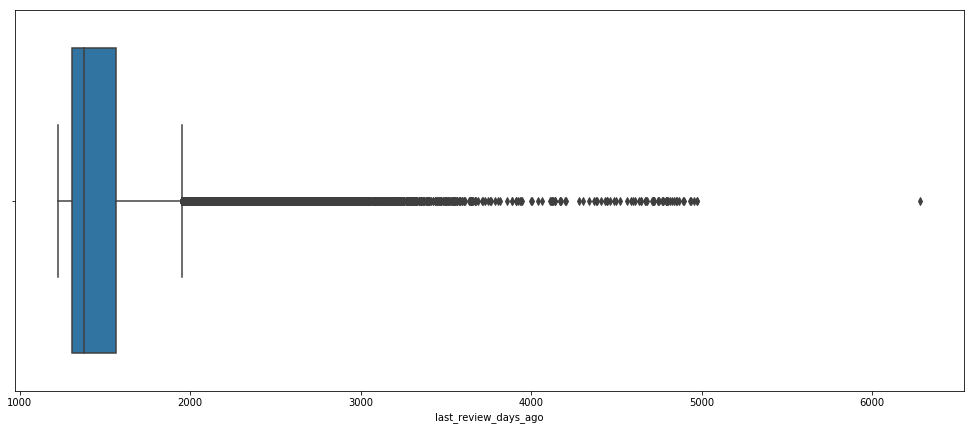

In [69]:
plt.subplots(figsize=(17, 7))
sns.boxplot(data['last_review_days_ago'])

In [70]:
# there is an obvious outlier more than 6000 days ago, let's change it to 5000
data['last_review_days_ago'] = data['last_review_days_ago'].apply(
    lambda x: 5000 if x >= 6000 else x)

In [71]:
# filling misses with mean value
data['last_review_days_ago'].fillna(
    round(data['last_review_days_ago'].mean()), inplace=True)
data['first_review_days_ago'].fillna(
    round(data['first_review_days_ago'].mean()), inplace=True)

In [72]:
# deleting dates as dates aren't valuable for ML
data.drop(['first_review', 'last_review'], axis=1, inplace=True)

In [73]:
data['Reviews']

0                                                 [[], []]
1        [['Very good reviews!', 'Fine dining in Hakani...
2        [['Better than the Links', 'Ivy Black'], ['12/...
3        [['Most exquisite', 'Delicious and authentic']...
4        [['Always the best in bratislava', 'Very good ...
                               ...                        
49995    [['The real Italian experience!', 'Wonderful f...
49996    [['Parisian atmosphere', 'Bit pricey but inter...
49997    [['Good by swedish standards', 'A hidden jewel...
49998    [['Underground restaurant', 'Oldest Restaurant...
49999    [['Average', 'Nice an informal'], ['01/31/2016...
Name: Reviews, Length: 50000, dtype: object

In [74]:
# extracting text from reviews
data['two_reviews'] = data['Reviews'].apply(
    lambda x: x.split('],')[0].split("',"))

# adding two columns with separate reviews
data['review_1'] = data['two_reviews'].apply(lambda x: x[0])
data['review_2'] = data['two_reviews'].apply(lambda x: x[-1])
data['review_1'] = data['review_1'].apply(
    lambda x: x.replace('[', '').replace("'", '').replace('"', ''))
data['review_2'] = data['review_2'].apply(
    lambda x: x.replace('[', '').replace("'", '').replace('"', ''))
data.drop('two_reviews', axis=1, inplace=True)

# deleting occasional duplicates
data['review_2'] = data[['review_2', 'review_1']].apply(
    lambda x: '' if x[0] == x[1] else x[0], axis=1)

In [75]:
# deleting Reviews as text have no value for ML
data.drop('Reviews', axis=1, inplace=True)

## Tonal analisys

For tonal analysis TextBlob is used.  The library  analyses text and returns  a value from -1 to 1, meaning tonal hue (-1 for negative, 0 for neutral and 1 for totally positive.

In [76]:
data['review_1'] = data['review_1'].apply(lambda x: TextBlob(x).polarity)
data['review_2'] = data['review_2'].apply(lambda x: TextBlob(x).polarity)

## URL_TA


In [77]:
len(data['URL_TA'].value_counts().loc[lambda x: x > 1])

37

There are 37 duplicates in  URL_TA attribute. 

In [78]:
# filering URL_TA values represented more then once and listing those.
data_URL_TA = data[data['URL_TA'].map(data['URL_TA'].value_counts()) > 1]
repeated_URL_TA = data_URL_TA['URL_TA'].tolist()

# duplicated URL_TA writed in a new attribute
data['twin_URL'] = data['URL_TA'].apply(
    lambda x: 1 if x in repeated_URL_TA else 0)

### 'ID_TA

In [79]:
data['ID_TA'].value_counts().loc[lambda x: x > 1]

d987900      2
d12488993    2
d2477531     2
d3685055     2
d7809594     2
d5618007     2
d1028622     2
d1315077     2
d1568045     2
d8753348     2
d2010743     2
d4600226     2
d11921719    2
d7337366     2
d2669414     2
d10440367    2
d4914988     2
d5617412     2
d9802625     2
d11999956    2
d3647024     2
d13002276    2
d3748757     2
d10047799    2
d1235635     2
d11674463    2
d793170      2
d4748208     2
d2360290     2
d7827387     2
d11698990    2
d7342803     2
d3396817     2
d9877640     2
d697406      2
d10316215    2
d3161682     2
Name: ID_TA, dtype: int64

In [80]:
# looking for duplicated ID
len(data['ID_TA'].value_counts().loc[lambda x: x > 1])

37

In [81]:
# filering ID_TA values represented more then once and listing those.
фильтруем значения  ID_TA, встречающиеся больше 1 раза и создаем список
data_ID_TA = data[data['ID_TA'].map(data['ID_TA'].value_counts()) > 1]
twins_ID_TA = data_ID_TA['ID_TA'].tolist()

# duplicated ID_TA writed in a new attribute
data['twin_ID_TA'] = data['ID_TA'].apply(
    lambda x: 1 if x in twins_ID_TA else 0)

In [82]:
# checking ID_TA length
ID_TA_len = data['ID_TA'].apply(lambda x: len(x))
ID_TA_len.value_counts()

8    33906
9    12050
7     4044
Name: ID_TA, dtype: int64

3 obvious groups are formed here. Let's check correlation with target attribute and write new attribute saving values ordering.

In [83]:
data['ID_TA_len'] = data['ID_TA'].apply(lambda x: len(x))

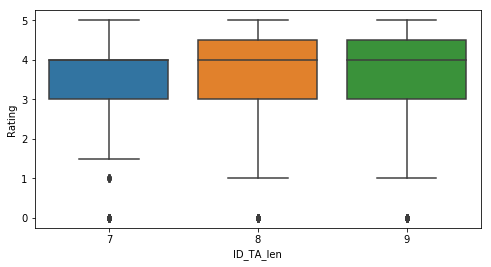

In [84]:
plt.subplots(figsize=(8, 4))
sns.boxplot(x='ID_TA_len', y='Rating', data=data)

In [85]:
# deliting literals and saving as a numeral feature
data['ID_TA'] = data['ID_TA'].apply(lambda x: int(x[1:]))

# Feature engineering


In [86]:
data.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating',
       'Cuisine Style_misses', 'Price Range_misses',
       'Number of Reviews_misses', 'Reviews_misses', 'twin_id',
       'rest_num_city', 'city_population', 'restaurants_density',
       'top_restaurants_count', 'cuisine_styles_num', 'city_top_ranking',
       'ranking_scaled', 'relative_ranking', 'norm_rest',
       'log_number_of_reviews', 'reviews_to_population', 'weighted_rank_pop',
       'review_dates', 'dates_count', 'between_reviews',
       'last_review_days_ago', 'first_review_days_ago', 'review_1', 'review_2',
       'twin_URL', 'twin_ID_TA', 'ID_TA_len'],
      dtype='object')

In [87]:
# for better training of a model let's normalize distributions

data['Ranking'] = get_min_max_normalization(data, 'Ranking')
data['Number of Reviews'] = get_min_max_normalization(
    data, 'Number of Reviews')
data['last_review_days_ago'] = get_min_max_normalization(
    data, 'last_review_days_ago')
data['between_reviews'] = get_min_max_normalization(data, 'between_reviews')
data['cuisine_styles_num'] = get_min_max_normalization(
    data, 'cuisine_styles_num')
data['city_population'] = get_min_max_normalization(data, 'city_population')
data['rest_num_city'] = get_min_max_normalization(data, 'rest_num_city')
data['between_reviews'] = get_min_max_normalization(data, 'between_reviews')
data['last_review_days_ago'] = get_min_max_normalization(
    data, 'last_review_days_ago')
data['first_review_days_ago'] = get_min_max_normalization(
    data, 'first_review_days_ago')

Let's enrich info about cities.

In [88]:
# Adding attribute of Capital
capital = ['Amsterdam', 'Athens', 'Berlin', 'Bratislava', 'Brussels', 'Budapest', 'Copenhagen', 'Dublin', 'Edinburgh', 'Helsinki',
           'Lisbon', 'Ljubljana', 'London', 'Luxembourg', 'Madrid', 'Oslo', 'Paris', 'Prague', 'Rome', 'Stockholm', 'Vienna', 'Warsaw']
data['capital'] = data['City'].apply(lambda x: 1 if x in (capital) else 0)

In [89]:
# adding dummy - variable for cities
data = pd.get_dummies(data, columns=['City'], dummy_na=False)

In [90]:
# trying polynomial features
pf = PolynomialFeatures(2)
poly_features = pf.fit_transform(data[['Ranking', 'Number of Reviews', ]])
poly_features

array([[1.00000000e+00, 7.88298972e-01, 4.00160064e-04, 6.21415270e-01,
        3.15445767e-04, 1.60128077e-07],
       [1.00000000e+00, 6.38569604e-03, 1.90076030e-02, 4.07771139e-05,
        1.21376775e-04, 3.61288973e-04],
       [1.00000000e+00, 4.92002676e-02, 5.20208083e-03, 2.42066633e-03,
        2.55943769e-04, 2.70616450e-05],
       ...,
       [1.00000000e+00, 1.00407468e-01, 4.00160064e-04, 1.00816597e-02,
        4.01790589e-05, 1.60128077e-07],
       [1.00000000e+00, 3.89223378e-02, 1.36054422e-02, 1.51494838e-03,
        5.29555616e-04, 1.85108057e-04],
       [1.00000000e+00, 2.93498753e-01, 5.16206483e-02, 8.61415182e-02,
        1.51505959e-02, 2.66469133e-03]])

In [91]:
df = pd.DataFrame(poly_features,
                  columns=['poly1', 'poly2', 'poly3', 'poly4', 'poly5', 'poly6'])
display(df)

,poly1,poly2,poly3,poly4,poly5,poly6
0,1.0,0.788299,0.000400,0.621415,0.000315,1.601281e-07
1,1.0,0.006386,0.019008,0.000041,0.000121,3.612890e-04
2,1.0,0.049200,0.005202,0.002421,0.000256,2.706164e-05
3,1.0,0.101441,0.040016,0.010290,0.004059,1.601281e-03
4,1.0,0.002189,0.032013,0.000005,0.000070,1.024820e-03
...,...,...,...,...,...,...
49995,1.0,0.030347,0.015406,0.000921,0.000468,2.373498e-04
49996,1.0,0.385574,0.108043,0.148668,0.041659,1.167334e-02
49997,1.0,0.100407,0.000400,0.010082,0.000040,1.601281e-07
49998,1.0,0.038922,0.013605,0.001515,0.000530,1.851081e-04


In [92]:
# adding polynomials to dataset
data['poly1'] = df['poly1']
data['poly2'] = df['poly2']
data['poly3'] = df['poly3']
data['poly4'] = df['poly4']
data['poly5'] = df['poly5']
data['poly6'] = df['poly6']

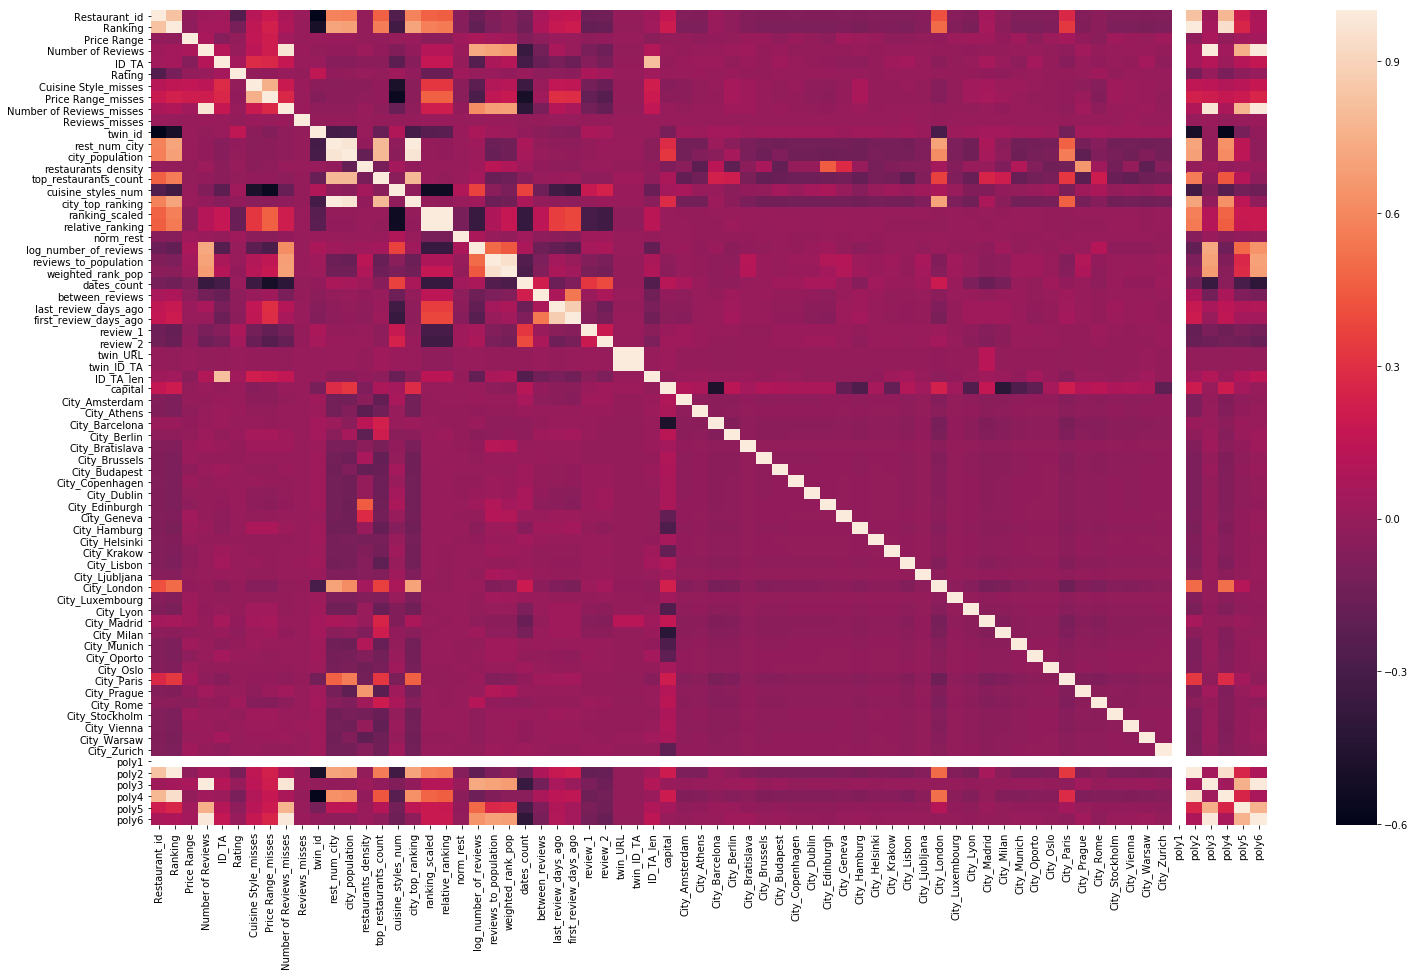

In [93]:
# illustrating linear correlation between attributes
plt.rcParams['figure.figsize'] = (25, 15)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

In [94]:
# cross checking
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 74 columns):
Restaurant_id               50000 non-null int64
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null float64
Number of Reviews           50000 non-null float64
URL_TA                      50000 non-null object
ID_TA                       50000 non-null int64
sample                      50000 non-null int64
Rating                      50000 non-null float64
Cuisine Style_misses        50000 non-null uint8
Price Range_misses          50000 non-null uint8
Number of Reviews_misses    50000 non-null uint8
Reviews_misses              50000 non-null uint8
twin_id                     50000 non-null int64
rest_num_city               50000 non-null float64
city_population             50000 non-null float64
restaurants_density         50000 non-null float64
top_restaurants_count       50000 non-null

In [95]:
data.columns

Index(['Restaurant_id', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating',
       'Cuisine Style_misses', 'Price Range_misses',
       'Number of Reviews_misses', 'Reviews_misses', 'twin_id',
       'rest_num_city', 'city_population', 'restaurants_density',
       'top_restaurants_count', 'cuisine_styles_num', 'city_top_ranking',
       'ranking_scaled', 'relative_ranking', 'norm_rest',
       'log_number_of_reviews', 'reviews_to_population', 'weighted_rank_pop',
       'review_dates', 'dates_count', 'between_reviews',
       'last_review_days_ago', 'first_review_days_ago', 'review_1', 'review_2',
       'twin_URL', 'twin_ID_TA', 'ID_TA_len', 'capital', 'City_Amsterdam',
       'City_Athens', 'City_Barcelona', 'City_Berlin', 'City_Bratislava',
       'City_Brussels', 'City_Budapest', 'City_Copenhagen', 'City_Dublin',
       'City_Edinburgh', 'City_Geneva', 'City_Hamburg', 'City_Helsinki',
       'City_Krakow', 'City_Lisbon', 'C

In [96]:
# droping highly correlated and useless for ML columns
data = data.drop(['Cuisine Style', 'URL_TA', 'review_dates', 'dates_count', 'poly1', 'twin_ID_TA',
                  'Ranking', 'Cuisine Style_misses', 'city_population', 'relative_ranking',
                  'reviews_to_population', 'review_dates', 'review_1', 'review_2'], axis=1)

In [97]:
data.head()

,Restaurant_id,Price Range,Number of Reviews,ID_TA,sample,Rating,Price Range_misses,Number of Reviews_misses,Reviews_misses,twin_id,...,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,poly2,poly3,poly4,poly5,poly6
0,0,2.0,0.000400,10746918,0,0.0,0,0,0,1,...,0,0,0,0,0,0.788299,0.000400,0.621415,0.000315,1.601281e-07
1,1,2.0,0.019008,6674944,0,0.0,0,0,0,1,...,0,0,0,0,0,0.006386,0.019008,0.000041,0.000121,3.612890e-04
2,2,2.0,0.005202,13129638,0,0.0,0,0,0,1,...,0,0,0,0,0,0.049200,0.005202,0.002421,0.000256,2.706164e-05
3,3,3.0,0.040016,680417,0,0.0,0,0,0,1,...,0,0,0,0,0,0.101441,0.040016,0.010290,0.004059,1.601281e-03
4,4,3.0,0.032013,1112354,0,0.0,0,0,0,1,...,0,0,0,0,0,0.002189,0.032013,0.000005,0.000070,1.024820e-03


# Data Preprocessing

In [98]:
# extracting training data
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values              # наш таргет
X = train_data.drop(['Rating'], axis=1)

# dividing to test and train data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 60), (40000, 60), (40000, 59), (32000, 59), (8000, 59))

# Model 
 ML

In [99]:
# Import libraries for model:

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # tool for valuation of model

In [100]:
# creating model (DO NOT TOUCH THE CUSTOMIZATION)
model = RandomForestRegressor(
    n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [101]:
# training model
model.fit(X_train, y_train)

# using model for prognosing rating in test data
# Prognosis is being written to y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [102]:
# comparing prognosed rating (y_pred) with real one (y_test) and counting
# Mean Absolute Error (MAE) showing mean deviation of prognosed values from real ones
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.19336250000000002


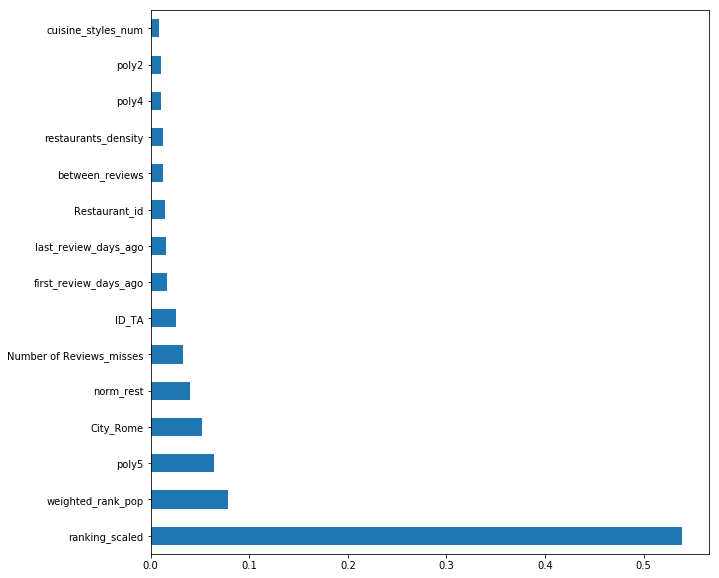

In [104]:
# in RandomForestRegressor it's possible to show the most important features used for prognosing
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
preparing submision for Kaggle 

In [105]:
test_data.sample(10)

,Restaurant_id,Price Range,Number of Reviews,ID_TA,Rating,Price Range_misses,Number of Reviews_misses,Reviews_misses,twin_id,rest_num_city,...,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,poly2,poly3,poly4,poly5,poly6
1610,1610,2.0,0.021809,797046,0.0,0,0,0,1,0.005882,...,0,0,0,0,0,0.015873,0.021809,0.000252,0.000346,4.756204e-04
2933,2933,2.0,0.002401,1050697,0.0,1,0,0,1,0.844355,...,0,0,0,0,0,0.700602,0.002401,0.490843,0.001682,5.764611e-06
5353,5353,2.0,0.019408,1799601,0.0,0,0,0,1,0.156649,...,0,0,0,0,0,0.112267,0.019408,0.012604,0.002179,3.766613e-04
2215,2215,2.0,0.014206,12215113,0.0,0,0,0,1,0.455171,...,0,0,0,0,0,0.089886,0.014206,0.008080,0.001277,2.018014e-04
2163,2163,2.0,0.013205,8087060,0.0,0,0,0,1,0.455171,...,0,0,0,0,0,0.135012,0.013205,0.018228,0.001783,1.743795e-04
8403,8403,2.0,0.000200,12338498,0.0,1,0,0,1,0.175154,...,0,0,1,0,0,0.176488,0.000200,0.031148,0.000035,4.003202e-08
5143,5143,2.0,0.000200,10060782,0.0,1,0,0,1,1.000000,...,0,0,0,0,0,0.581038,0.000200,0.337605,0.000116,4.003202e-08
5185,5185,2.0,1.000000,12322378,0.0,1,1,0,1,0.515134,...,0,0,0,0,0,0.533114,1.000000,0.284211,0.533114,1.000000e+00
1739,1739,2.0,0.001601,10092485,0.0,1,0,0,1,0.085641,...,0,0,0,0,0,0.105090,0.001601,0.011044,0.000168,2.562049e-06
6711,6711,2.0,0.000000,7954530,0.0,1,0,0,1,0.116339,...,0,1,0,0,0,0.132822,0.000000,0.017642,0.000000,0.000000e+00


In [106]:
test_data = test_data.drop(['Rating'], axis=1)

In [107]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [108]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [109]:
predict_submission

array([3.13 , 4.185, 4.295, ..., 3.06 , 4.475, 4.4  ])

In [110]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.130
1,id_1,4.185
2,id_2,4.295
3,id_3,4.400
4,id_4,4.445
5,id_5,4.460
6,id_6,1.685
7,id_7,3.655
8,id_8,4.220
9,id_9,4.695
